# Łańcuch Markowa

## Schemat uczenia modelu

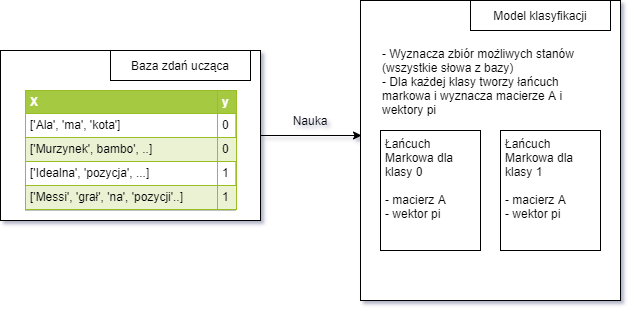

## Schemat predykcji

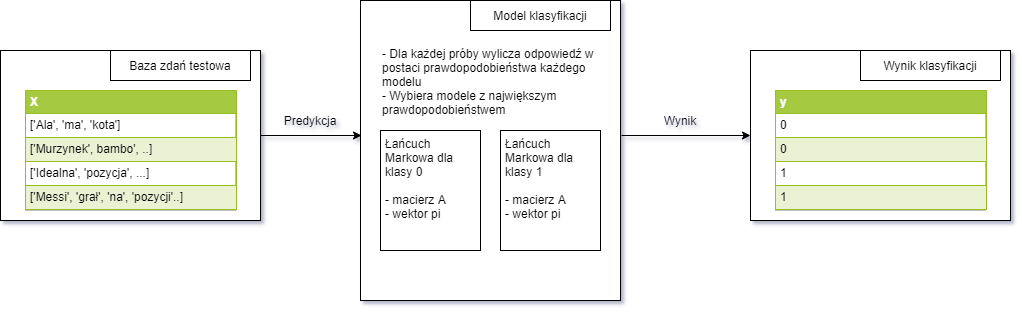


## Przygotowanie bazy

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split

flatten = lambda t: [item for sublist in t for item in sublist]

def preprocess_data(path, label):
    f = open(path, encoding="utf8")
    expose = ''.join(f.readlines())

    chars_to_remove = ['+', ',', '-', ':', ';', '?', '–', '”', '„', '…', '\n', '\n\n', '  ', '%', '(', ')', '\xad', '/']
    for char in chars_to_remove: 
        expose = expose.replace(char, ' ')
    expose = expose.lower()

    sentences = expose.split('. ')
    words_in_sentences = np.array([sentence.split() for sentence in sentences], dtype=object)
    
    X = np.reshape(words_in_sentences, (-1, 1))
    y = np.ones(X.shape) * label
    data = np.hstack((X, y))
    
    return X, y

In [2]:
X_tusk, y_tusk = preprocess_data('data/tusk2011.txt', 0)
X_szydlo, y_szydlo = preprocess_data('data/szydlo2015.txt', 1)
X_morawiecki, y_morawiecki = preprocess_data('data/morawiecki2019.txt', 2)
X_kopacz, y_kopacz = preprocess_data('data/kopacz2014.txt', 3)

In [3]:
X = np.vstack((X_tusk, X_szydlo, X_morawiecki, X_kopacz))
y = np.vstack((y_tusk, y_szydlo, y_morawiecki, y_kopacz))

In [4]:
words = flatten(flatten(X))
states = np.unique(words).tolist()

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Klasyfikator gdzie stany modelu Markowa to słowa

In [6]:
class MarkovChain:
    def __init__(self, X, states):
        self.A = np.zeros((len(states), len(states)))
        self.pi = np.zeros(len(states))
        self.states = states
        print(f"MarkovChain created from {X.shape}")
        
        for sentence in X:
            if sentence == []:
                continue
            index_first_word = states.index(sentence[0])
            self.pi[index_first_word] += 1
            for i in range(1, len(sentence)):
                prev_state = states.index(sentence[i-1])
                curr_state = states.index(sentence[i])
                self.A[prev_state, curr_state] += 1
        self.pi = self.pi/np.sum(self.pi)
        sums_for_state = np.sum(self.A, axis=1, keepdims=True)
        sums_for_state[sums_for_state == 0] = 1  # prevents dividing by zero
        self.A = self.A/sums_for_state
        self.A[self.A == 0] = 1e-4
        self.pi[self.pi == 0] = 1e-4
        self.A = self.A/np.sum(self.A, axis=1, keepdims=True)  # normalization (I think its optional)
        
    def predict_proba(self, X):
        probas = []
        for index in range(X.shape[0]):
            sentence = X[index, 0]
            if sentence == []:
                continue
            proba = 0
            index_first_word = self.states.index(sentence[0])
            first_char_proba = np.log(self.pi[index_first_word])
            if first_char_proba != 0:
                proba = proba + first_char_proba
            
            for i in range(1, len(sentence)):
                prev_state = self.states.index(sentence[i-1])
                curr_state = self.states.index(sentence[i])
                transition_proba = self.A[prev_state, curr_state]
                if transition_proba != 0:
                    proba = proba + np.log(transition_proba)
            probas.append(proba)
        return probas

In [7]:
from sklearn.base import BaseEstimator, ClassifierMixin

class MarkovClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, states=None):
        self.markov_chains = {}
        self.states = states
        self.classes_ = None
        
    def fit(self, X, y):
        if self.states is None:
            # prepare states
            words = flatten(flatten(X))
            self.states = np.unique(words).tolist()
        
        # prepare models
        self.classes_ = np.unique(y)
        for label in self.classes_:
            self.markov_chains[label] = MarkovChain(X[y == label], self.states)
        
        print(self.markov_chains)
    
    def predict_probas(self, X):
        probas = np.zeros((X.shape[0], len(self.markov_chains)))
        for idx, label in enumerate(self.classes_):
            probas[:, idx] = self.markov_chains[label].predict_proba(X)
        return probas
    
    def predict(self, X):
        return np.argmax(self.predict_probas(X), axis=1)

## Testowanie klasyfikatora

In [8]:
mc = MarkovClassifier(states)
mc.fit(X_train, y_train)

MarkovChain created from (194,)
MarkovChain created from (304,)
MarkovChain created from (420,)
MarkovChain created from (217,)
{0.0: <__main__.MarkovChain object at 0x00000280DC079488>, 1.0: <__main__.MarkovChain object at 0x00000280DBDCE248>, 2.0: <__main__.MarkovChain object at 0x00000280DBFF1CC8>, 3.0: <__main__.MarkovChain object at 0x00000280DBD062C8>}


In [9]:
y_pred = mc.predict(X_test)

In [10]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[48,  7, 12, 12],
       [32, 70, 28, 26],
       [34, 36, 73, 26],
       [16, 17, 19, 31]], dtype=int64)

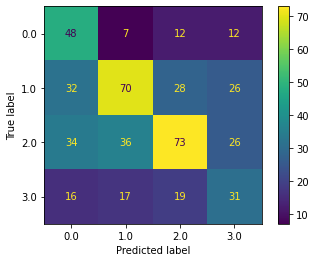

In [11]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(mc, X_test, y_test)

In [12]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.45585215605749485

In [13]:
conf_matrix[0, 0] / np.sum(conf_matrix[0, :])

0.6075949367088608

In [14]:
conf_matrix[1, 1] / np.sum(conf_matrix[1, :])

0.44871794871794873

In [15]:
conf_matrix[2, 2] / np.sum(conf_matrix[2, :])

0.4319526627218935

In [16]:
conf_matrix[3, 3] / np.sum(conf_matrix[3, :])

0.37349397590361444

## Dokładność na nieznanych danych

In [17]:
X_morawiecki_2, y_morawiecki_2 = preprocess_data('data/morawiecki2.txt', 2)
y_pred = mc.predict(X_test)

words = flatten(flatten(X_morawiecki_2))
states = states + np.unique(words).tolist()

In [18]:
mc = MarkovClassifier(states)
mc.fit(X, y)

MarkovChain created from (273,)
MarkovChain created from (460,)
MarkovChain created from (589,)
MarkovChain created from (300,)
{0.0: <__main__.MarkovChain object at 0x00000280C410A248>, 1.0: <__main__.MarkovChain object at 0x00000280C403AF08>, 2.0: <__main__.MarkovChain object at 0x00000280C3FCF408>, 3.0: <__main__.MarkovChain object at 0x00000280C4105F08>}


In [19]:
y_pred = mc.predict(X_morawiecki_2)

In [20]:
conf_matrix = confusion_matrix(y_morawiecki_2, y_pred)
conf_matrix

array([[  0,   0,   0,   0],
       [  0,   0,   0,   0],
       [125, 139, 178,  88],
       [  0,   0,   0,   0]], dtype=int64)

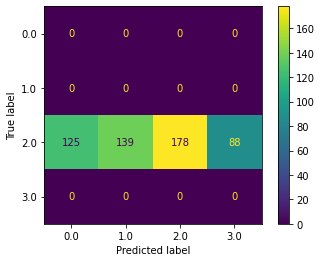

In [21]:
plot_confusion_matrix(mc, X_morawiecki_2, y_morawiecki_2)

In [22]:
from sklearn.metrics import accuracy_score
accuracy_score(y_morawiecki_2, y_pred)

0.33584905660377357